<a href="https://colab.research.google.com/github/catenaccianna/cse402/blob/main/facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cite: https://github.com/heorhii-bolotov/facenet
!unzip -qq data.zip

**Define function-helpers for data preprocessing**

In [ ]:
import os 
import glob 

from PIL import Image, ImageDraw


def get_files(path='./', ext=('.png', '.jpeg', '.jpg')):
    """ Get all image files """
    files = []
    for e in ext:
        files.extend(glob.glob(f'{path}/**/*{e}'))
    files.sort(key=lambda p: (os.path.dirname(p), int(os.path.basename(p).split('.')[0])))
    return files

def to_rgb_and_save(path):
    """ Some of the images may have RGBA mode """
    for p in path:
        img = Image.open(p)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
            img.save(p)

**Define image path**



In [ ]:
ABS_PATH = '/content/'
DATA_PATH = os.path.join(ABS_PATH, 'data')
 
TRAIN_DIR = os.path.join(DATA_PATH, 'train_images')
TEST_DIR = os.path.join(DATA_PATH, 'test_images')

ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

**Preparing data**

In [ ]:
from collections import Counter 


# 1. Get path for TRAIN_DIR/TEST_DIR
trainF, testF = get_files(TRAIN_DIR), get_files(TEST_DIR)

# prepare info for printing
trainC, testC = Counter(map(os.path.dirname, trainF)), Counter(map(os.path.dirname, testF))
train_total, train_text  = sum(trainC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in trainC.items()])
test_total, test_text  = sum(testC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in testC.items()])

print(f'Train files\n\tpath: {TRAIN_DIR}\n\ttotal number: {train_total}\n{train_text}')
print(f'Test files\n\tpath: {TEST_DIR}\n\ttotal number: {test_total}\n{test_text}')

Train files
	path: /content/data/train_images
	total number: 20
	- Person1 - 2
	- Person10 - 2
	- Person2 - 2
	- Person4 - 2
	- Person5 - 2
	- Person6 - 2
	- Person7 - 2
	- Person8 - 2
	- Person9 - 2
	- Preson3 - 2
Test files
	path: /content/data/test_images
	total number: 10
	- Person1 - 1
	- Person10 - 1
	- Person2 - 1
	- Person3 - 1
	- Person4 - 1
	- Person5 - 1
	- Person6 - 1
	- Person7 - 1
	- Person8 - 1
	- Person9 - 1


In [ ]:
# 2. Convert all img to RGB 
to_rgb_and_save(trainF), to_rgb_and_save(testF)

(None, None)

**Image plotter fuctions**

In [ ]:
from math import ceil 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline  

from matplotlib.patches import Ellipse


def imshow(img, ax, title):  
    ax.imshow(img)
    if title:
        el = Ellipse((2, -1), 0.5, 0.5)
        ax.annotate(title, xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom',
                    bbox=dict(boxstyle="round", fc="0.8"), 
                    arrowprops=dict(arrowstyle="simple", fc="0.6", ec="none", 
                                    patchB=el, connectionstyle="arc3, rad=0.3"))
    ax.set_xticks([]), ax.set_yticks([])

def plot_gallery(images, ncols, nrows, titles=None, title='', figsize=None): 
    if figsize is None: 
        figsize = (18, ncols) if ncols < 10 else (18, 20)  
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.02)

    for i, ax in enumerate(grid): 
        if i == len(images): break 
        imshow(images[i], ax, titles[i] if titles is not None else '')

    # there are some problems with suptitle alignment 
    y_title_pos = grid[0].get_position().get_points()[1][1] - 0.33 / (1 if nrows == 1 else nrows / 3)
    plt.suptitle(title, y=y_title_pos, fontsize=12)

def plot(paths=None, images=None, titles=None, axtitle=True, title='', to_size=(512, 512)): 
    """
    Plot image gallery by passing (paths, title) or (images, titles)
    :param paths: list of image paths
    :param images: list of (PIL.Image | np.array | torch.Tensor) objects 
    :param titles: list of image titles 
    :param bool axtitle: if paths is not None, then axtitle=True leads to use basedir name as titles 
    :param str title: gallery title   
    :param to_size: image resizing size before plot, default (512, 512)
    """

    if paths is not None and len(paths): 
        images = [Image.open(p).resize(to_size) for p in paths]

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        if axtitle: 
              titles = [os.path.dirname(p).split('/')[-1] for p in paths]

        plot_gallery(images, ncols, nrows, titles, title)

    elif images is not None and len(images): 
        if isinstance(images, list): 
            images = np.array(images)

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        # Rescale to [0., 1.]
        if images[0].max() > 1: 
            images /= 255. 

        # if torch.Tensor change axes 
        if not isinstance(images, np.ndarray): 
            if images.size(1) == 3 or 1: 
                images = images.permute((0, 2, 3, 1))

        plot_gallery(images, ncols, nrows, titles, title)


    else: 
        raise LookupError('You didnt pass any path or image objects')
    plt.show()

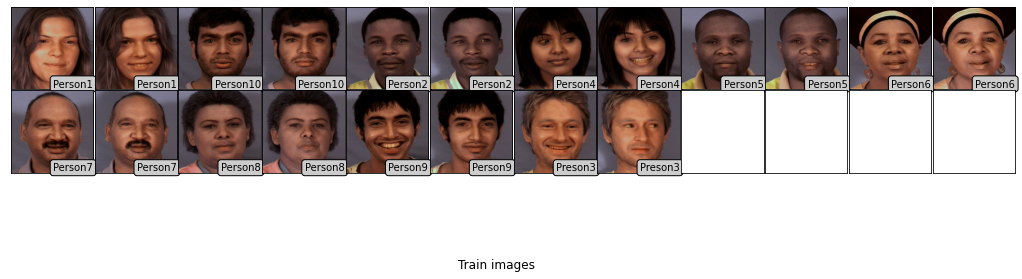

In [ ]:
plot(paths=trainF, title='Train images')

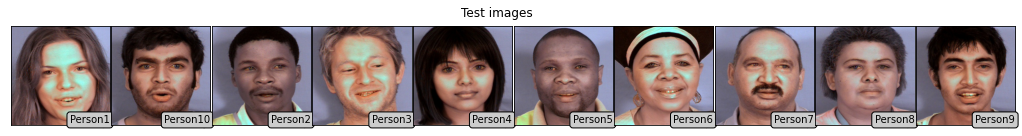

In [ ]:
plot(paths=testF, title='Test images')

**Install facenet_pytorch with MTCNN detection and pretrained vggface-2 InceptionResnetV1**

In [ ]:
!pip install facenet-pytorch 

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Function for cropping and saving images based on MTCNN detector**

In [ ]:
import tqdm 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np

import shutil

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')


def crop_face_and_save(path, new_path=None, model=MTCNN, transformer=None, params=None):
    """
    Detect face on each image, crop them and save to "new_path"
    :param str path: path with images will be passed to  datasets.ImageFolder
    :param str new_path: path to locate new "aligned" images, if new_path is None 
                     then new_path will be path + "_cropped" 
    :param model: model to detect faces, default MTCNN  
    :param transformer: transformer object will be passed to ImageFolder
    :param params: parameters of MTCNN model   
    """
    if not new_path: 
        new_path = path + '_cropped'

    # in case new_path exists MTCNN model will raise error 
    if os.path.exists(new_path):
        shutil.rmtree(new_path)

    # it is default parameters for MTCNN 
    if not params:
        params = {
            'image_size': 160, 'margin': 0, 
            'min_face_size': 10, 'thresholds': [0.6, 0.7, 0.7],
            'factor': 0.709, 'post_process': False, 'device': device
            }
    
    model = model(**params)

    if not transformer:
        transformer = transforms.Lambda(
            lambd=lambda x: x.resize((1280, 1280)) if (np.array(x) > 2000).all() else x
        )
    # for convenience we will use ImageFolder instead of getting Image objects by file paths  
    dataset = datasets.ImageFolder(path, transform=transformer)
    dataset.samples = [(p, p.replace(path, new_path)) for p, _ in dataset.samples]

    # batch size 1 as long as we havent exact image size and MTCNN will raise an error
    loader = DataLoader(dataset, batch_size=1, collate_fn=training.collate_pil)
    for i, (x, y) in enumerate(tqdm.tqdm(loader)): 
        model(x, save_path=y)

    # spare some memory 
    del model, loader, dataset 

Running on device: cuda:0


**Detect/Crop faces and save "new" aligned images**

In [ ]:
# 3. Crop train dataset faces and save aligned images 
print('\t- Train data')
crop_face_and_save(TRAIN_DIR, ALIGNED_TRAIN_DIR)

# check if some imgs were missed by detector and failed to save 
train_files, train_aligned_files = get_files(TRAIN_DIR), get_files(ALIGNED_TRAIN_DIR)
if len(train_files) != len(train_aligned_files): 
    files = set(map(lambda fp: os.path.relpath(fp, start=TRAIN_DIR), train_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TRAIN_DIR), train_aligned_files))
    detect_failed_train_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

# -------------                     -------------

# Crop test dataset faces and save aligned images 
print('\t- Test data')
crop_face_and_save(TEST_DIR, ALIGNED_TEST_DIR)

# check if some imgs were missed by detector and failed to save 
test_files, test_aligned_files = get_files(TEST_DIR), get_files(ALIGNED_TEST_DIR)
if len(test_files) != len(test_aligned_files): 
    files = set(map(lambda fp: os.path.relpath(fp, start=TEST_DIR), test_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TEST_DIR), test_aligned_files))
    detect_failed_test_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

	- Train data


100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


	- Test data


100%|██████████| 10/10 [00:00<00:00, 21.51it/s]


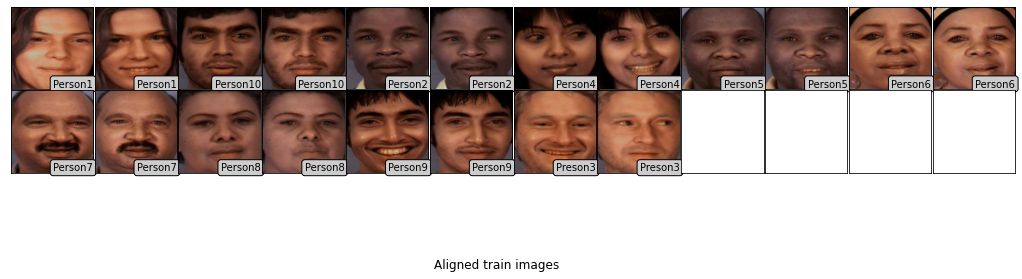

In [ ]:
trainF = get_files(ALIGNED_TRAIN_DIR)
plot(paths=trainF, title='Aligned train images')

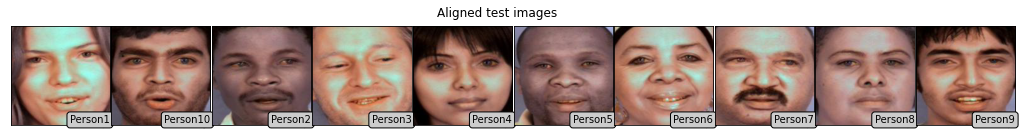

In [ ]:
testF = get_files(ALIGNED_TEST_DIR)
plot(paths=testF, title='Aligned test images')

In [ ]:
# # Plot failed to aligned train images
# trainFailF = list(map(lambda fp: os.path.join(TRAIN_DIR, fp), detect_failed_train_files))
# plot(paths=trainFailF)

**Install albumentations for augmentations**

In [ ]:
!pip install albumentations

import albumentations as A

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Transformer for data**

In [ ]:
from facenet_pytorch import fixed_image_standardization

standard_transform = transforms.Compose([
                                np.float32, 
                                transforms.ToTensor(),
                                fixed_image_standardization
])

aug_mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.15),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.OneOrOther(A.JpegCompression(p=0.2), A.Blur(p=0.2), p=0.66),
                   A.OneOf([
                            A.Rotate(45, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
], p=1)

transform = {
    'train': transforms.Compose([
                                 transforms.Lambda(lambd=lambda x: aug_mask(image=np.array(x))['image']),
                                 standard_transform
    ]),
    'test': standard_transform
}

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:778: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(


**DataLoader for train/test**

In [ ]:
from torch.utils.data import SubsetRandomSampler


b = 32

# Original train images 
trainD = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=standard_transform)
# Augmented train images 
trainD_aug = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
# Train Loader
trainL = DataLoader(trainD, batch_size=b, num_workers=2) # x: torch.Size([batch_size, 3, 160, 160]), y: torch.Size([batch_size])
trainL_aug = DataLoader(trainD_aug, batch_size=b, num_workers=2)

# Original test images 
testD = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=standard_transform)
# Test Loader
testL = DataLoader(testD, batch_size=b, num_workers=2)

# Convert encoded labels to named claasses
IDX_TO_CLASS = np.array(list(trainD.class_to_idx.keys()))
CLASS_TO_IDX = dict(trainD.class_to_idx.items())


**Prepare model**

In [ ]:
from facenet_pytorch import InceptionResnetV1

model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()

**Function for embedding extraction**

In [ ]:
def fixed_denormalize(image): 
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

def getEmbeds(model, n, loader, imshow=False, n_img=5):
    model.eval()
    # images to display 
    images = []

    embeds, labels = [], []
    for n_i in tqdm.trange(n): 
        for i, (x, y) in enumerate(loader, 1): 

            # on each first batch get 'n_img' images  
            if imshow and i == 1: 
                inds = np.random.choice(x.size(0), min(x.size(0), n_img))
                images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

            embed = model(x.to(device))
            embed = embed.data.cpu().numpy()
            embeds.append(embed), labels.extend(y.data.cpu().numpy())

    if imshow: 
        plot(images=np.concatenate(images))

    return np.concatenate(embeds), np.array(labels)

**Extract embeddings**

100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


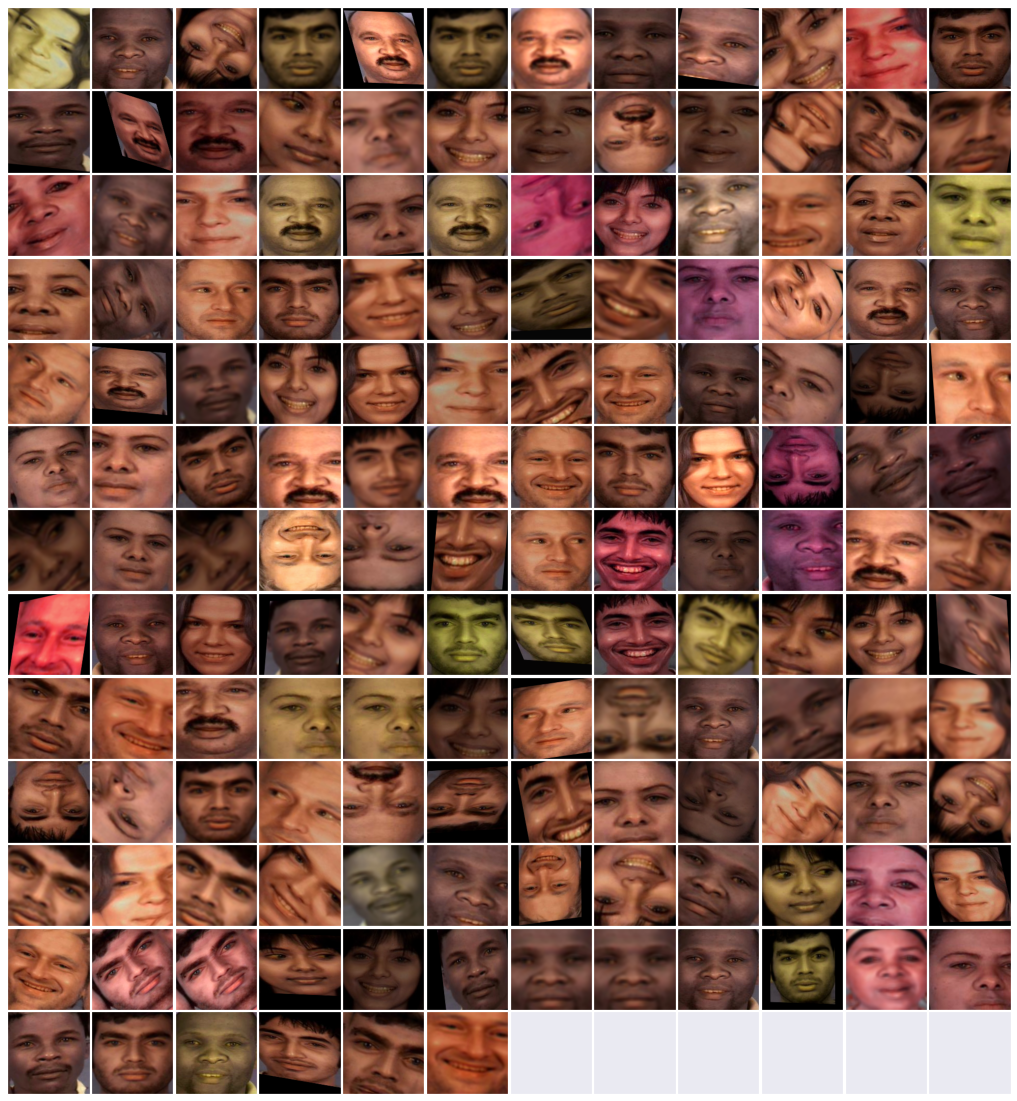

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


In [ ]:
# 3. Get embeddings 
# Train embeddings 
trainEmbeds, trainLabels = getEmbeds(model, 1, trainL, False)
trainEmbeds_aug, trainLabels_aug = getEmbeds(model, 50, trainL_aug, imshow=True, n_img=3)

trainEmbeds = np.concatenate([trainEmbeds, trainEmbeds_aug])
trainLabels = np.concatenate([trainLabels, trainLabels_aug])

# Test embeddings 
testEmbeds, testLabels = getEmbeds(model, 1, testL, False)

In [ ]:
# 4. Save embeddings 
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'testEmbeds.npz')

np.savez(TRAIN_EMBEDS, x=trainEmbeds, y=trainLabels)
np.savez(TEST_EMBEDS, x=testEmbeds, y=testLabels)

# Load the saved embeddings to use them futher 
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()

# Get named labels
trainLabels, testLabels = IDX_TO_CLASS[trainLabels], IDX_TO_CLASS[testLabels]

**Function for embedding calculations**

In [ ]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns 
sns.set()

def getDist(x, metric='euclidean', index=None, columns=None):
    dists = pairwise_distances(x, x, metric=metric)
    return pd.DataFrame(dists, index=index, columns=columns)

def heatmap(x, title='', cmap='Greens', linewidth=1):
    plt.figure(figsize=(17, 12))
    plt.title(title)
    sns.heatmap(x, cmap=cmap, square=True)
    plt.show()

**Get distance matrix for each image embedding**

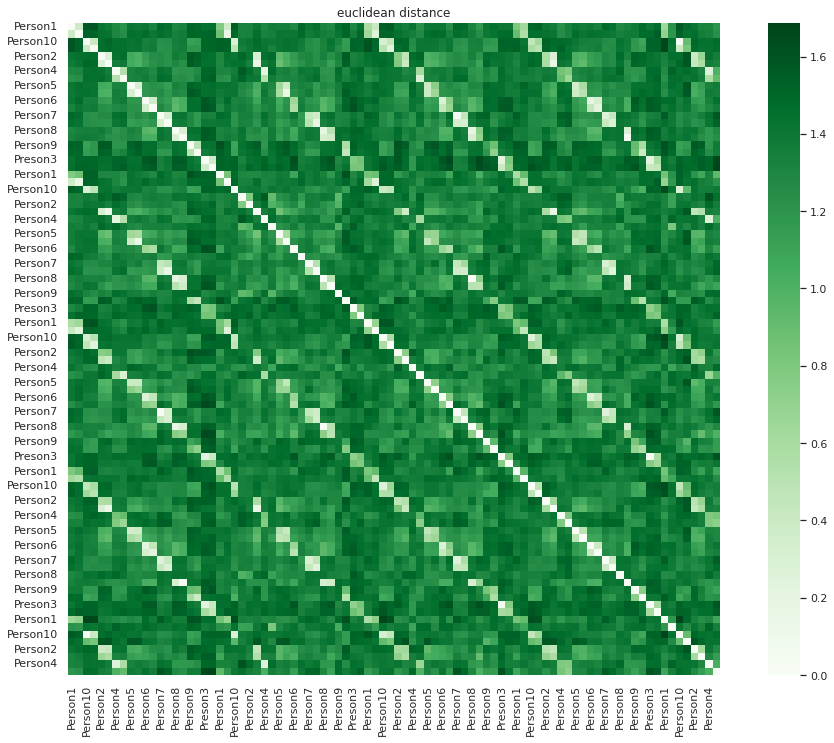

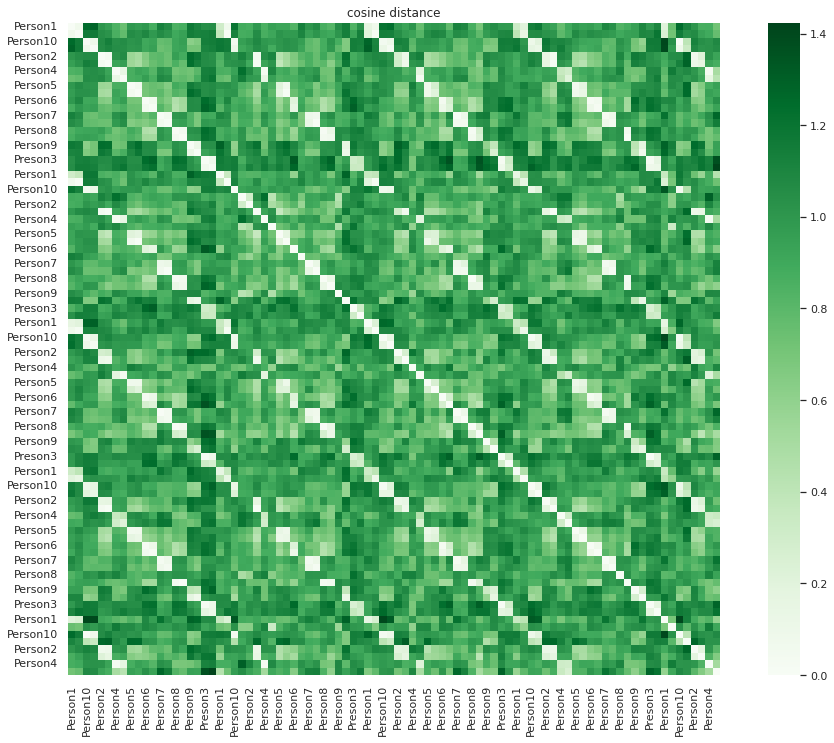

In [ ]:
# Note 88 first images are original and 4247 are augmented
# as long as to calculate (4335, 512) distance matrix is time consuming we get only distances of originals 
inds = range(88)

# Train embeddings 
dists = getDist(trainEmbeds[inds], metric='euclidean', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'euclidean distance')

dists = getDist(trainEmbeds[inds], metric='cosine', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'cosine distance')

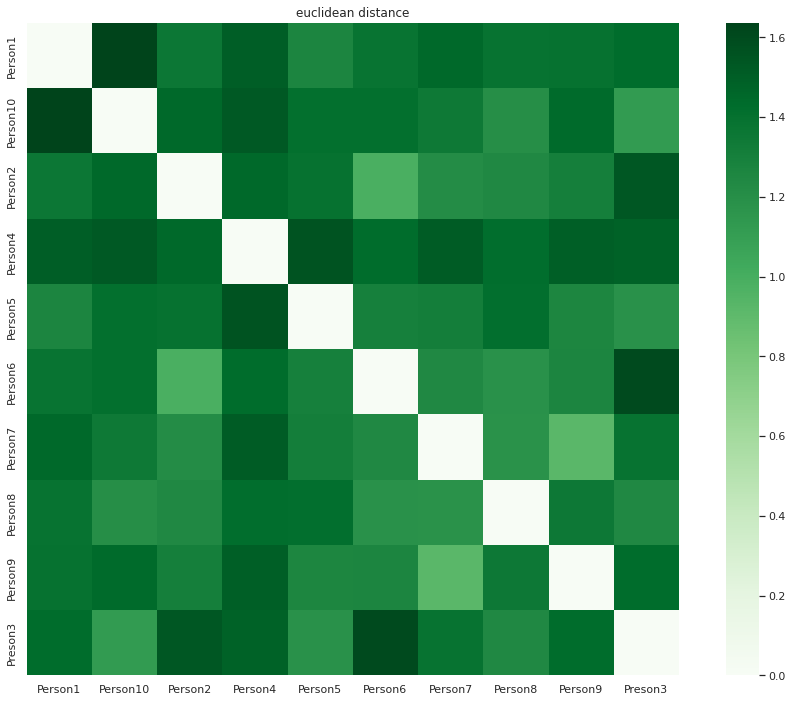

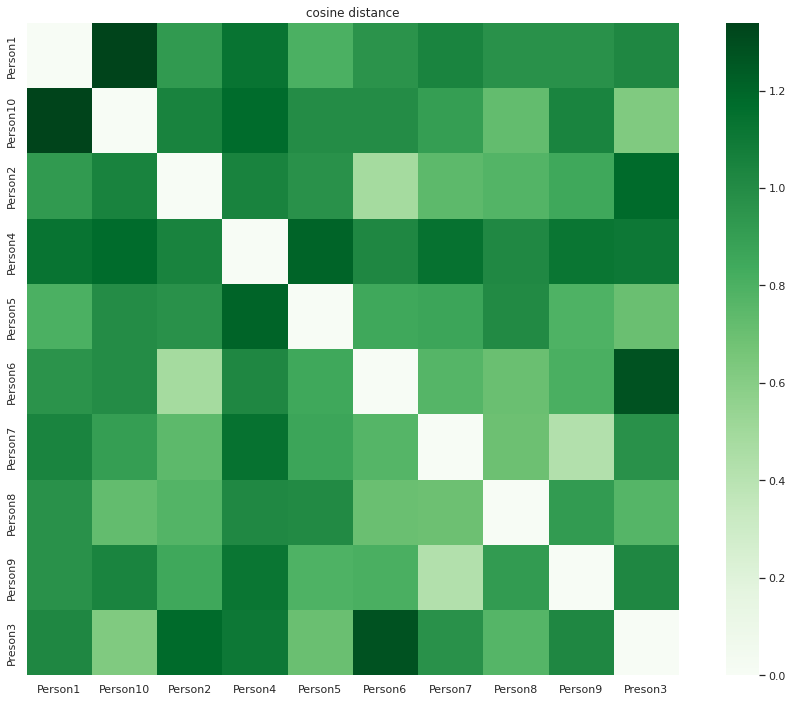

In [ ]:
# Test embeddings 
dists = getDist(testEmbeds, metric='euclidean', index=testLabels, columns=testLabels)
heatmap(dists, 'euclidean distance')

dists = getDist(testEmbeds, metric='cosine', index=testLabels, columns=testLabels)
heatmap(dists, 'cosine distance')

**Take a look at how TSNE & PCA methods clustered our images**

<ipython-input-70-354dc571d05c>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(np.unique(trainLabels[inds]))


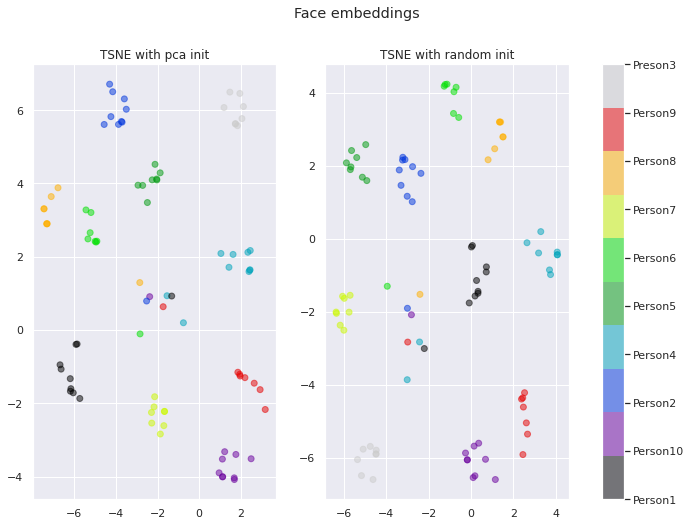

In [ ]:
from sklearn.manifold import TSNE


inds = range(88)
X_tsne1 = TSNE(n_components=2, init='pca', random_state=33).fit_transform(trainEmbeds[inds])
X_tsne2 = TSNE(n_components=2, init='random', random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

img = ax[0].scatter(X_tsne1[:, 0], X_tsne1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
ax[1].scatter(X_tsne2[:, 0], X_tsne2[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))

ax[0].set_title('TSNE with pca init')
ax[1].set_title('TSNE with random init')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

In [ ]:
from sklearn.decomposition import PCA


inds = range(88)
X_pca1 = PCA(n_components=2, random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
img = ax.scatter(X_pca1[:, 0], X_pca1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.title('PCA method')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

**Find optimal parameters for SVC classifier and train**

In [ ]:
# data preparation 
X = np.copy(trainEmbeds)
y = np.array([CLASS_TO_IDX[label] for label in trainLabels])

print(f'X train embeds size: {X.shape}')
print(f'Tagret train size: {y.shape}')

**As we see, in order to find optimal parameters among ```'param_grid'``` the whole search process took ~ 1.5 hours**

In [ ]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings('ignore', 'Solver terminated early.*')

param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 'auto'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
model_params = {'class_weight': 'balanced', 'max_iter': 10, 'probability': True, 'random_state': 3}
model = SVC(**model_params)
clf = GridSearchCV(model, param_grid)
clf.fit(X, y)

print('Best estimator: ', clf.best_estimator_)
print('Best params: ', clf.best_params_)

**Load & save SVC model, basically weights**

In [ ]:
# SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
# # joblib.dump(clf, SVM_PATH)
# clf = joblib.load(SVM_PATH)

**Check the accuracy score on Train & Test datasets(embeddings)**

In [ ]:
# test data preparation 
X_test, y_test = np.copy(testEmbeds), np.array([CLASS_TO_IDX[label] for label in testLabels])
print(f'X train embeds size: {X_test.shape}')
print(f'Tagret train size: {y_test.shape}')

In [ ]:
from sklearn.metrics import accuracy_score

inds = range(88)
train_acc = accuracy_score(clf.predict(X[inds]), y[inds])
print(f'Accuracy score on train data: {train_acc:.3f}')

test_acc = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy score on test data: {test_acc}')